In [2]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 1. Human_Pose_Estimation

### MPII Human Pose Dataset
MPII Human Pose Dataset은 인간 포즈 추정 분야에서 가장 많이 사용되는 데이터셋 중 하나이다. 이 데이터셋은 41000개의 이미지와 이들 이미지에 대한 인간 포즈의 위치 정보를 포함하고 있다. 이 데이터셋은 MPII(막스 플랑크 인간 개발 및 인지과학 연구소)에서 제공하며, 다양한 분야에서 사용된다.

MPII Human Pose Dataset에 포함된 이미지들은 다양한 배경과 조명 조건에서 촬영된 것으로, 포즈 예측 모델의 강인성과 일반화 능력을 평가하는 데 매우 유용하다. 또한, 이 데이터셋은 다양한 인간 포즈 추정 모델들의 학습에도 활용되고 있다.

## (1) 데이터 전처리하기

In [3]:
PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### 1) JSON 파싱하기

JSON 파싱은 보통 JSON 데이터를 문자열 형태로 읽어온 뒤, 이를 해당 프로그래밍 언어에서 사용 가능한 데이터 구조(예: 리스트, 딕셔너리, 객체 등)로 변환하는 과정을 의미한다. 이렇게 파싱된 데이터는 프로그래밍 언어에서 쉽게 다룰 수 있으며, 필요한 정보를 추출하거나 데이터를 가공하는 등의 다양한 작업에 활용된다.

In [4]:
# JSON 파일을 열어 샘플로 annotation 정보를 1개 출력하기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


joints가 우리가 label로 사용할 keypoint의 label이다. 
이미지 형상과 사람의 포즈에 따라 모든 label이 이미지에 나타나지 않기 때문에 
joints_vis를 이용해서 실제로 사용할 수 있는 keypoint인지 나타낸다. 
MPII의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있다. 
coco의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label화 되어 있다.

joints 순서는 아래와 같은 순서로 배치되어 있다.

- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

scale과 center는 사람 몸의 크기와 중심점이다.
scale은 200을 곱해야 온전한 크기가 되므로, 추후에 전처리 과정에서 200을 곱해서 사용할 예정이다.

### JSON annotation을 파싱하는 함수 만들기

JSON(annotation) 파싱은 JSON 형식으로 작성된 어노테이션 파일을 읽어들여서 필요한 정보를 추출하는 과정을 말한다. 이는 일반적으로 컴퓨터 비전 분야에서 객체 검출, 분할, 인식 등을 수행하는 딥러닝 모델을 학습시키거나 평가할 때 사용된다.

JSON(annotation) 파일은 객체의 위치, 크기, 클래스 등과 같은 정보를 포함하고 있다. 이러한 정보를 파싱하여, 예를 들어 딥러닝 모델의 입력 이미지와 매칭시켜 객체의 위치와 클래스를 식별할 수 있다.

In [6]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

# parse_one_annotation() 함수를 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


## (2) TFRecord 파일 만들기

### 1) TFRecord 파일 만들기

TFRecord는 TensorFlow에서 사용되는 바이너리 데이터 포맷 중 하나이다. TFRecord 파일은 데이터 집합을 담고 있으며, 각 데이터는 여러 개의 속성(feature)로 구성된다. 이 포맷은 대규모 데이터셋을 다룰 때 사용하며, 빠르게 데이터를 읽고 쓸 수 있다.

In [7]:
# 추출한 annotation을 TFRecord로 변환하는 함수

def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results


# 하나의 chunk를 TFRecord로 만들어 줄 함수 만들기

@ray.remote    # Ray : 병렬 처리를 위한 라이브러리
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)
    

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

## (3) Ray

Ray는 분산 시스템에서 작업을 병렬화하고 조정하는 라이브러리이다. 
Ray를 사용하면 여러 컴퓨터 노드에서 작업을 실행하고, 작업 간에 데이터를 공유할 수 있으며, 
이를 통해 빠르고 효율적인 분산 처리를 구현할 수 있다.

In [10]:
# 작성한 함수를 사용해 데이터를 TFRecord로 만들기

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2023-03-20 11:01:15,723	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.80gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

## (4) data label로 만들기

In [16]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example, image_feature_description)

## (5) Hourglass Model 만들기

In [18]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

## (6) 학습 엔진 만들기

### 1) GPU가 여러 개인 환경

<!-- 이제 모델 학습을 진행할 차례입니다.

그런데 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까요? 
여러 GPU를 사용하기 위해서는 약간의 코드를 추가해줘야 합니다. 
학습 환경은 GPU가 하나이지만 나중에 기업 환경에서 여러 GPU를 사용할 수 있으니 살짝 공부해 봅시다.

Distributed training with Keras

가장 핵심 키워드는 tf.distribute.MirroredStrategy입니다. 
한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법인데요. 
여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 
그런 후 모델의 가중치를 업데이트 하도록 하는 것이죠.

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 
strategy.reduce 함수가 담당합니다.

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어 봅니다. -->

In [21]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [22]:
# 데이터셋을 만드는 함수를 작성

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [23]:
# 데이터셋과 모델, 훈련용 객체를 조립하여 하나의 함수로 만들기

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

### 2) 모델 학습하기

In [24]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

## (7) 예측 엔진 만들기
미리 학습된 모델을 불러와서 학습이 끝난 모델이 얼마나 잘 예측하는지 확인하기

In [25]:
model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(best_model_file)

In [26]:
# 학습에 사용했던 keypoint들을 사용해야 하기 때문에 필요한 변수를 지정 (변수에 저장되는 것은 해당 부위를 나타내는 인덱스)

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [28]:
# heatmap으로부터 좌표를 추출

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


# 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줌

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


# 모델과 이미지 경로를 입력하여 이미지와 keypoint를 출력하는 함수를 만들기

def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [29]:
# 그림 그리기 (keypoint들과 뼈대)

# keypoint들: 관절 역할
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

# keypoint들을 연결시킨 것: 뼈대
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

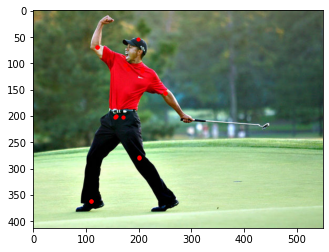

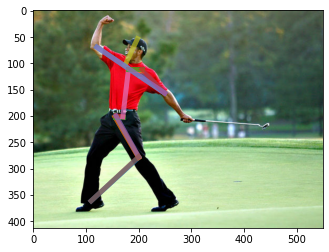

In [30]:
### 테스트 이미지를 이용해 모델의 성능 확인

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')
image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

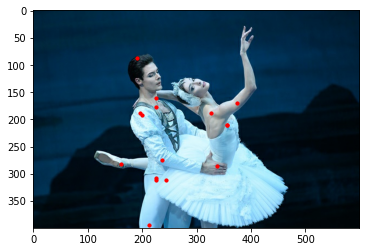

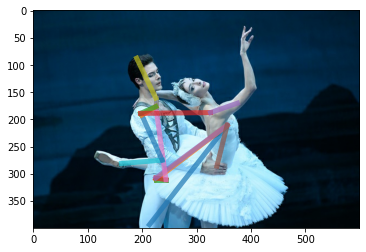

In [39]:
test_image = os.path.join(PROJECT_PATH, 'test_image_2.jpeg')
image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

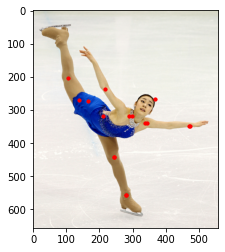

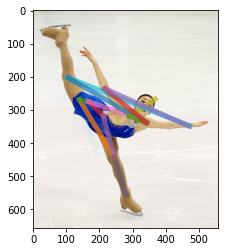

In [73]:
test_image = os.path.join(PROJECT_PATH, 'test_image_3.jpeg')
image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

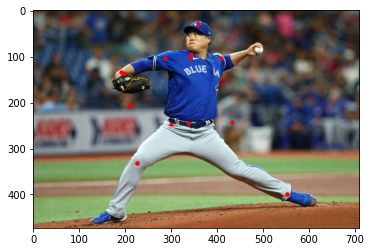

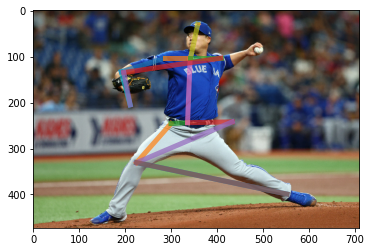

In [74]:
test_image = os.path.join(PROJECT_PATH, 'test_image_4.jpeg')
image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# 2. Project_Simple_Baseline_Model

## (1) Simple Baseline Model 만들기

In [108]:
def SimpleBaselineModel(
        input_shape=(256, 256, 3),
        num_stack=1,
        num_heatmap=16,
        num_keypoints=1):

    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    x = MaxPool2D(pool_size=2, strides=2)(x)

    x = Conv2D(
        filters=128,
        kernel_size=3,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    x = Conv2D(
        filters=128,
        kernel_size=3,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    x = Conv2D(
        filters=256,
        kernel_size=3,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    x = Conv2D(
        filters=256,
        kernel_size=3,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    ys = []
    for i in range(num_stack):
        x = Conv2D(
            filters=256,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

    return tf.keras.Model(inputs, ys, name='simple_baseline')

## (2) Simple Baseline Model로 변경하여 훈련하기

### 1) GPU가 여러 개인 환경

In [109]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))
        
        
# 데이터셋을 만드는 함수를 작성
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


# 데이터셋과 모델, 훈련용 객체를 조립하여 하나의 함수로 만들기

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = SimpleBaselineModel(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

### 2) 모델 학습하기

In [110]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file_SBL = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 5.60874 epoch total loss 5.60874
Trained batch 2 batch loss 15.9945698 epoch total loss 10.8016548
Trained batch 3 batch loss 6.16178656 epoch total loss 9.25503254
Trained batch 4 batch loss 3.31270313 epoch total loss 7.76945
Trained batch 5 batch loss 4.28254318 epoch total loss 7.07206869
Trained batch 6 batch loss 3.29128 epoch total loss 6.44193697
Trained batch 7 batch loss 2.52270412 epoch total loss 5.8820467
Trained batch 8 batch loss 2.67750692 epoch total loss 5.48147917
Trained batch 9 batch loss 2.81119204 epoch total loss 5.1847806
Trained batch 10 batch loss 2.56984544 epoch total loss 4.92328739
Trained batch 11 batch loss 2.26758385 epoch total loss 4.68186
Trained batch 12 batch loss 2.03155041 epoch total loss 4.46100092
Trained batch 13 batch loss 2.2

## (3) 두 모델의 비교

### 1) Hourglass Model

#### 학습 진행 경과 (loss 감소 현황)

- model-epoch-1-loss-1.4184.h5
- model-epoch-2-loss-1.2946.h5
- model-epoch-3-loss-1.2263.h5
- model-epoch-4-loss-1.1983.h5
- model-epoch-5-loss-1.1729.h5 → best_model

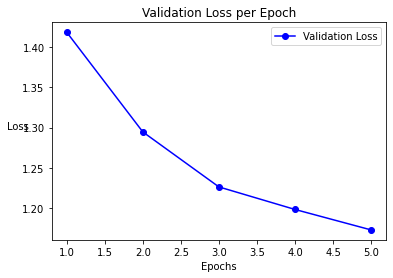

In [112]:
losses = [1.4184, 1.2946, 1.2263, 1.1983, 1.1729]
epochs = list(range(1, len(losses) + 1))

plt.plot(epochs, losses, 'bo-', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=0)
plt.legend()
plt.show()

### 2) Simple Baseline Model

#### 학습 진행 경과 (loss 감소 현황)

- model-epoch-1-loss-1.7053.h5
- model-epoch-1-loss-1.7240.h5
- model-epoch-3-loss-1.6518.h5
- model-epoch-4-loss-1.6410.h5
- model-epoch-5-loss-1.6077.h5 → best_model

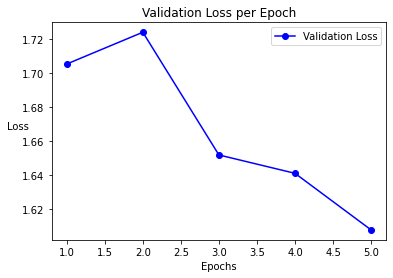

In [113]:
losses = [1.7053, 1.7240, 1.6518, 1.6410, 1.6077]
epochs = list(range(1, len(losses) + 1))

plt.plot(epochs, losses, 'bo-', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=0)
plt.legend()
plt.show()

# 3. Conclusion

### Hourglass Model vs. Simple Baseline Model

두 모델을 비교 분석하기 위해 학습 과정에서의 loss 감소 현황을 살펴보면, Hourglass Model이 Simple Baseline Model보다 더 높은 성능을 보이는 것을 알 수 있다. Hourglass Model의 best model에서의 validation loss 값은 1.1729이고, Simple Baseline Model의 best model에서의 validation loss 값은 1.6077이다.

또한, Hourglass Model과 Simple Baseline Model은 각각 다른 아키텍처를 사용하기 때문에 모델의 특성에 따라 성능이 달라질 수 있다. Hourglass Model은 hourglass-shaped network를 사용하여 입력 이미지의 여러 스케일에서 특징 맵을 추출하고, 이를 통해 점진적으로 특징을 통합하여 결과를 도출하는 방식으로 동작한다. 반면 Simple Baseline Model은 각 스케일에서 특징을 추출하고, 이를 연속적으로 레이어에 전달하여 결과를 도출한다.

따라서, Hourglass Model이 Simple Baseline Model보다 더 높은 성능을 보인 이유는 Hourglass Model이 입력 이미지의 여러 스케일에서 특징을 추출하고 이를 점진적으로 통합하여 결과를 도출하는 방식이 더 효과적이었기 때문일 것으로 추정된다.

Hourglass Model의 장점은 다양한 레이어의 네트워크 구조를 사용하여 다양한 스케일의 이미지 정보를 처리할 수 있다는 것이다. Hourglass Model은 Residual Connection을 사용하여 학습을 더욱 빠르게 하며, 이미지 내에서 물체의 크기와 모양이 다양한 경우에도 좋은 성능을 보인다. 하지만 Hourglass Model은 모델의 크기와 복잡성 때문에 학습에 많은 계산 자원이 필요하며, 학습 시간도 오래 걸릴 수 있다.

Simple Baseline Model은 Hourglass Model과 비교하여 구조가 더 간단하다. 그러나 이 모델은 Hourglass Model만큼 성능이 우수하지는 않다. Simple Baseline Model의 장점은 Hourglass Model보다 빠르게 학습할 수 있으며, 모델의 크기가 작기 때문에 작은 기기에서도 실행할 수 있다는 것이다. 또한 Simple Baseline Model은 이미지 내의 물체 크기나 모양의 변화에 더 잘 대응할 수 있다.

Hourglass Model은 높은 정확도를 원하는 경우에 적합하며, Simple Baseline Model은 빠른 학습과 작은 디바이스에서의 실행이 필요한 경우에 적합하다.

# 4. References

[1] https://lms.aiffel.io/course/405/node/489/step/3297

[2] https://arxiv.org/pdf/1804.06208.pdf